In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
DEVICE = 'cuda:0'
dataset_dir = "Elriggs/openwebtext-100k"
# import sys
# sys.path.append(home_dir)

import torch as t
from transformers import AutoTokenizer
from tqdm import tqdm
from nnsight import LanguageModel
import torch as t
import matplotlib.pyplot as plt

from dictionary_learning import ActivationBuffer, AutoEncoder
from dictionary_learning.dictionary import GatedAutoEncoder
from dictionary_learning.interp import examine_dimension
from dictionary_learning.utils import hf_dataset_to_generator
# import imageio
import os

ImportError: attempted relative import with no known parent package

In [3]:
#%%
# Model setup
# You should put HF_API_KEY.txt in the project root directory
# This is needed to download the Llama models from the Hugging Face model hub
# This is useful when people use different API keys in different projects
with open("../HF_API_KEY.txt", "r") as file:
    hf_api_key = file.read().strip()
os.environ['HF_TOKEN']=hf_api_key

model_name = 'meta-llama/Meta-Llama-3-8B'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
model = LanguageModel(
    model_name,
    tokenizer=tokenizer,
    dispatch=True,
    device_map=DEVICE,
    torch_dtype=t.bfloat16,
)
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/hufy/dictionary_learning/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [4]:
from huggingface_hub import hf_hub_download
ae_path = hf_hub_download("canrager/llama3_sae", "ae_250000.pt")
ae = GatedAutoEncoder.from_pretrained(ae_path).to(DEVICE)

In [5]:
#%%
layer = 16
submodule = model.model.layers[layer]
d_submodule = model.config.hidden_size
expension_factor=32
dictionary_size = d_submodule * expension_factor

#%%

generator = hf_dataset_to_generator(dataset_dir)
buffer = ActivationBuffer(
    data=generator,
    model=model,
    submodule=submodule,
    d_submodule=d_submodule,
    io='out',
    n_ctxs=128,
    ctx_len=128,
    refresh_batch_size=64, # batches for buffer internal activations
    out_batch_size=128, # batches for training
    device=DEVICE
)

In [6]:
feat_idx = 13570
top_contexts, top_tokens, top_affected = examine_dimension(model, submodule, buffer, dictionary=ae, dim_idx=feat_idx, n_inputs=16)
print(top_tokens)
print(top_affected)
top_contexts

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[('<|begin_of_text|>', 0.0), ('Port', 0.0), ('-au', 0.0), ('-', 0.0), ('Prince', 0.0), (',', 0.0), (' Haiti', 0.0), (' (', 0.0), ('CNN', 0.0), (')', 0.0), (' --', 0.0), (' Earth', 0.0), ('quake', 0.0), (' victims', 0.0), (' wr', 0.0), ('ith', 0.0), ('ing', 0.0), (' in', 0.0), (' pain', 0.0), (' and', 0.0), (' gras', 0.0), ('ping', 0.0), (' at', 0.0), (' life', 0.0), (' watched', 0.0), (' doctors', 0.0), (' nurses', 0.0), (' walk', 0.0), (' away', 0.0), (' from', 0.0)]
[('.DefaultCellStyle', 0.022611498832702637), ('еф', 0.022123217582702637), (' map', 0.021634817123413086), ('ABS', 0.020414233207702637), ('erial', 0.020292162895202637), ('RM', 0.020231127738952637), (' Flood', 0.020200669765472412), ('.FirebaseAuth', 0.020170092582702637), (' (', 0.020169943571090698), ('.EntityFramework', 0.020169854164123535), ('0', 0.019742965698242188), ('ES', 0.019071459770202637), ('ラス', 0.018949389457702637), (' »', 0.01894932985305786), ('_depend', 0.018705248832702637), ('TRS', 0.0185831785202

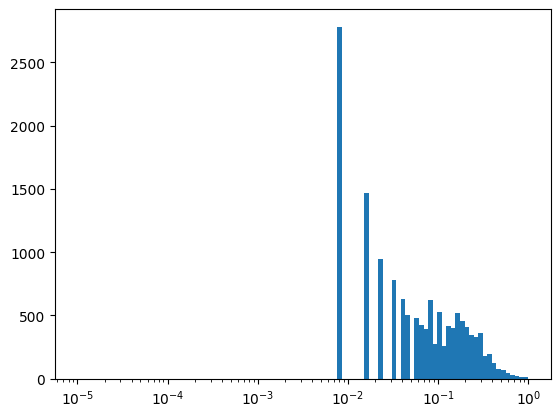

In [7]:
acts = next(buffer)
f = ae.encode(acts.cuda())
freqs = (f != 0).sum(dim=0) / f.shape[0]

plt.figure()
plt.hist(freqs.cpu(), bins=t.logspace(-5, 0, 100))
plt.xscale('log')

In [8]:
acts = next(buffer)
f = ae.encode(acts)
freqs = (f != 0).sum(dim=0) / f.shape[0]
for idx, freq in enumerate(freqs):
    if 3e-3 < freq and freq < 1e-2:
        print(f"feat {idx} freq: {freq}")

feat 118 freq: 0.0078125
feat 125 freq: 0.0078125
feat 167 freq: 0.0078125
feat 206 freq: 0.0078125
feat 225 freq: 0.0078125
feat 255 freq: 0.0078125
feat 319 freq: 0.0078125
feat 472 freq: 0.0078125
feat 493 freq: 0.0078125
feat 564 freq: 0.0078125
feat 720 freq: 0.0078125
feat 742 freq: 0.0078125
feat 951 freq: 0.0078125
feat 980 freq: 0.0078125
feat 997 freq: 0.0078125
feat 1070 freq: 0.0078125
feat 1097 freq: 0.0078125
feat 1104 freq: 0.0078125
feat 1117 freq: 0.0078125
feat 1134 freq: 0.0078125
feat 1166 freq: 0.0078125
feat 1187 freq: 0.0078125
feat 1264 freq: 0.0078125
feat 1280 freq: 0.0078125
feat 1289 freq: 0.0078125
feat 1335 freq: 0.0078125
feat 1375 freq: 0.0078125
feat 1411 freq: 0.0078125
feat 1449 freq: 0.0078125
feat 1474 freq: 0.0078125
feat 1475 freq: 0.0078125
feat 1478 freq: 0.0078125
feat 1488 freq: 0.0078125
feat 1552 freq: 0.0078125
feat 1582 freq: 0.0078125
feat 1596 freq: 0.0078125
feat 1653 freq: 0.0078125
feat 1663 freq: 0.0078125
feat 1691 freq: 0.0078125
f